## Defining Value class for back and forward pass

In [4]:
import math
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    #printing
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, label={self.label})"
    
    #adding
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other): # other + self
        return self + other
    
    #substract
    def __sub__(self, other):  
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __rsub__(self,other):
        return self - other
    
    # mul
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self * other
    
    #division
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self,other), "/")
        def _backward():
            self.grad += out.grad / other.data
            other.grad -= self.data * out.grad / (other.data * other.data)
        
        out._backward = _backward
        return out
    
    def __rtruediv__(self,other):
        return other * self**-1
        
    #negative
    def __neg__(self): # -self
        return self * -1
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        # e**2x -1   / e**2x +1
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            # 1-tanh**2 * x
            self.grad += (1 - t ** 2) * out.grad
            
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        
        def _backward():
            if out.data > 0:
                self.grad += 1 * out.grad
            else:
                self.grad = 0
        
        out._backward = _backward
        return out
    
        
    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")
        
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        
        out._backward = _backward
        return out
    
    def log(self):
        out = Value(math.log(self.data), (self,), "log")
        
        def _backward():
            self.grad += out.grad / self.data
            
        out._backward = _backward
        return out
        
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

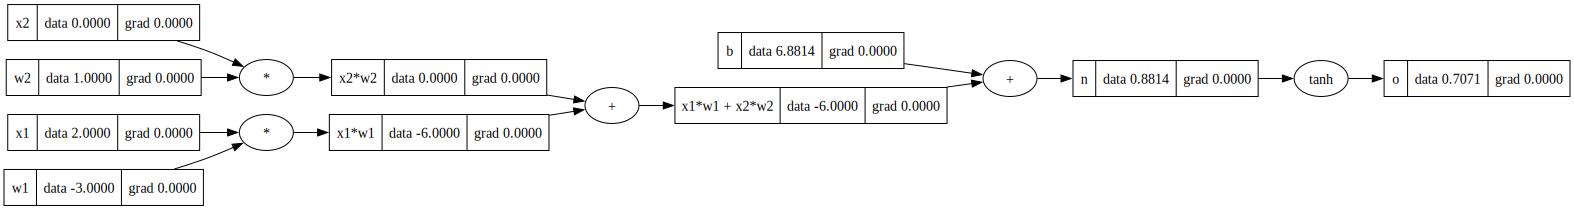

In [7]:
draw_dot(o)

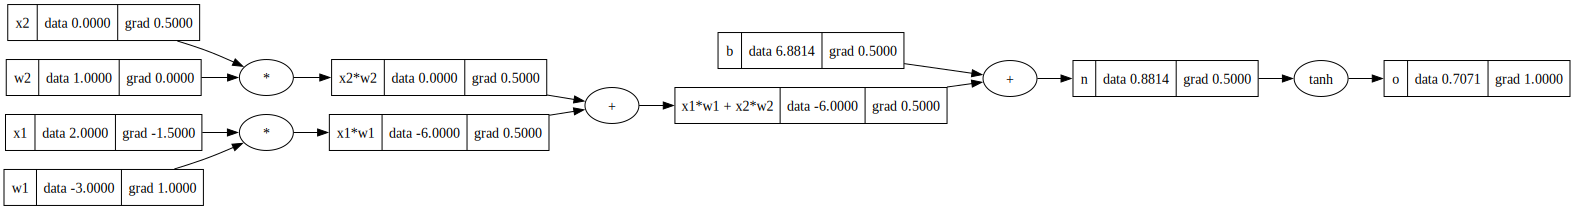

In [8]:
o.backward()
draw_dot(o)

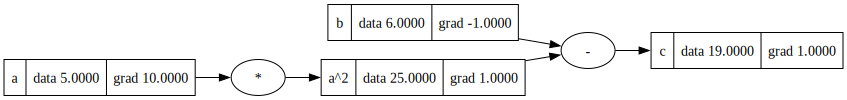

In [9]:
a = Value(5.0, label='a')
a2 = a*a; a2.label="a^2"
b = Value(6., label="b")
c = (a2) - b; c.label="c"

c.backward()
draw_dot(c)

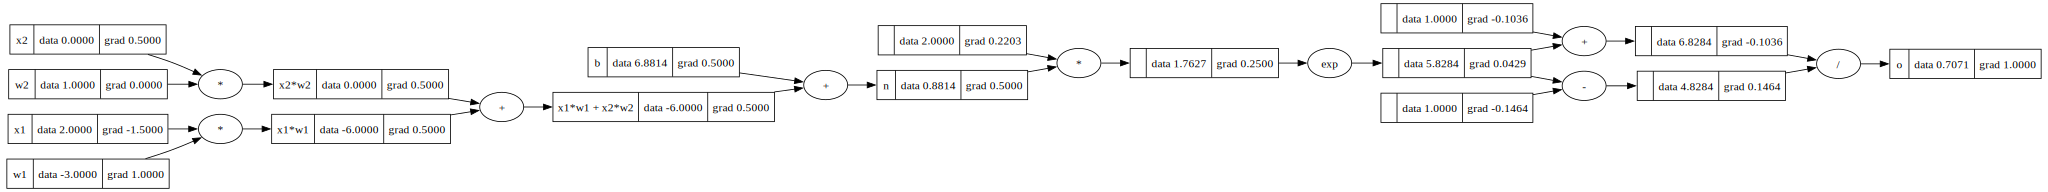

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [11]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


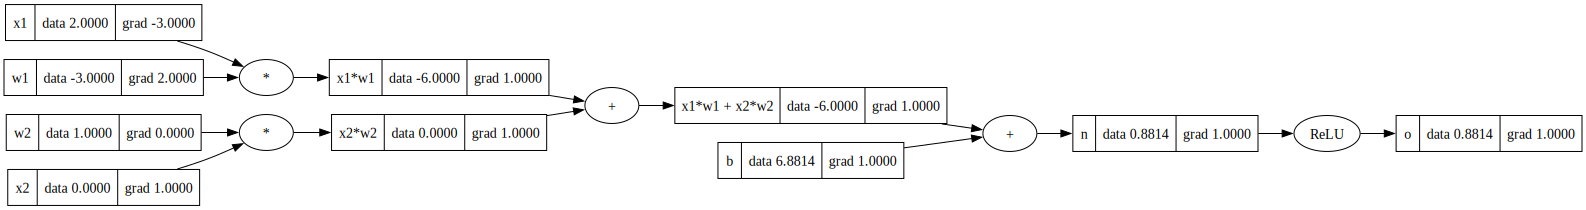

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
o = n.relu(); o.label = 'o'
o.backward()
draw_dot(o)

In [13]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.relu(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.881373405456543
---
x2 1.0
w2 0.0
x1 -3.0
w1 2.0


In [14]:
import random
random.uniform(-1,1)

0.4609690989010673

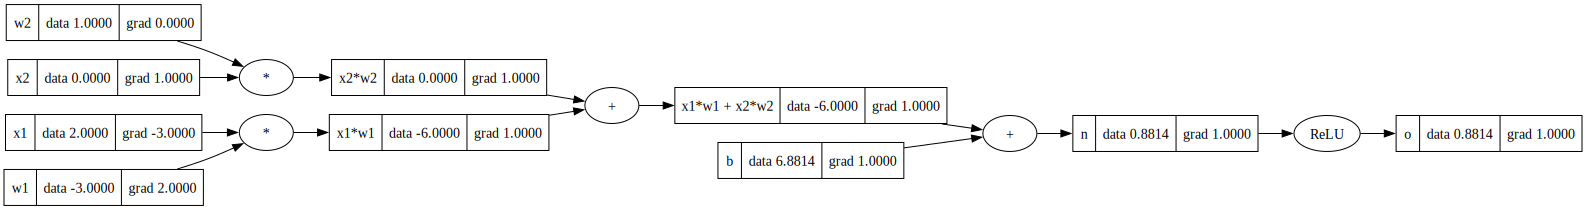

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
o = n.relu(); o.label = 'o'
o.backward()
draw_dot(o)

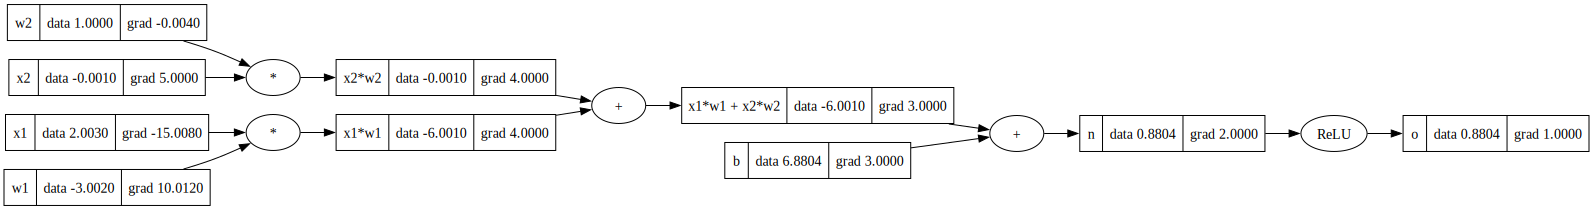

In [16]:
alpha = 0.001
x1.data -=       alpha * x1.grad
x2.data -=       alpha * x2.grad
w1.data -=       alpha * w1.grad
w2.data -=       alpha * w2.grad
x1w1.data -=     alpha * x1w1.grad
x2w2.data -=     alpha * x2w2.grad
x1w1x2w2.data -= alpha * x1w1x2w2.grad
b.data -=        alpha * b.grad
n.data -=        alpha * n.grad
o.data -=        alpha * n.grad
o.backward()
draw_dot(o)

In [17]:
class Neuron:
    
    def __init__(self, nin, activation = "linear"):
        #weight * x + bias
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) # bias
        self.activation = activation
        
    def __call__(self, x):
        
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) # w*x + b
        return act.relu() if self.activation == "relu" \
        else act.tanh() if self.activation == "tanh" \
        else act
        
    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{self.activation} Neuron({len(self.w)})"
    
    
class Layer:
    
    def __init__(self, nin, nout, activation="linear"):
        # how many neuron we want in 1 single layer = nout
        self.neurons = [Neuron(nin,activation=activation) for _ in range(nout)]
        
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out)==1 else out
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            n_params = neuron.parameters()
            params.extend(n_params)
        return params
       
class MLP:
    def __init__(self, nin, nouts, activation="linear"):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], activation=activation) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            l_params = layer.parameters()
            params.extend(l_params)
        return params
    

In [18]:
x = [2.,3.]

layer = Layer(2,3) # 2 dimensional 3 neuron = 3 neuron with (w1 * x1) + (w2 * x2) + b
layer(x)

[Value(data=-1.2031948941369734, grad=0.0, label=),
 Value(data=0.3096734445132341, grad=0.0, label=),
 Value(data=0.40321371974113296, grad=0.0, label=)]

In [19]:
layer.parameters()

[Value(data=-0.5249950951253521, grad=0.0, label=),
 Value(data=-0.3098892074182149, grad=0.0, label=),
 Value(data=0.7764629183683756, grad=0.0, label=),
 Value(data=0.7236806663594679, grad=0.0, label=),
 Value(data=-0.36170310705919917, grad=0.0, label=),
 Value(data=-0.05257856702810426, grad=0.0, label=),
 Value(data=-0.03703963084538442, grad=0.0, label=),
 Value(data=0.05386903781283103, grad=0.0, label=),
 Value(data=0.3156858679934087, grad=0.0, label=)]

In [20]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=2.046695362237652, grad=0.0, label=)

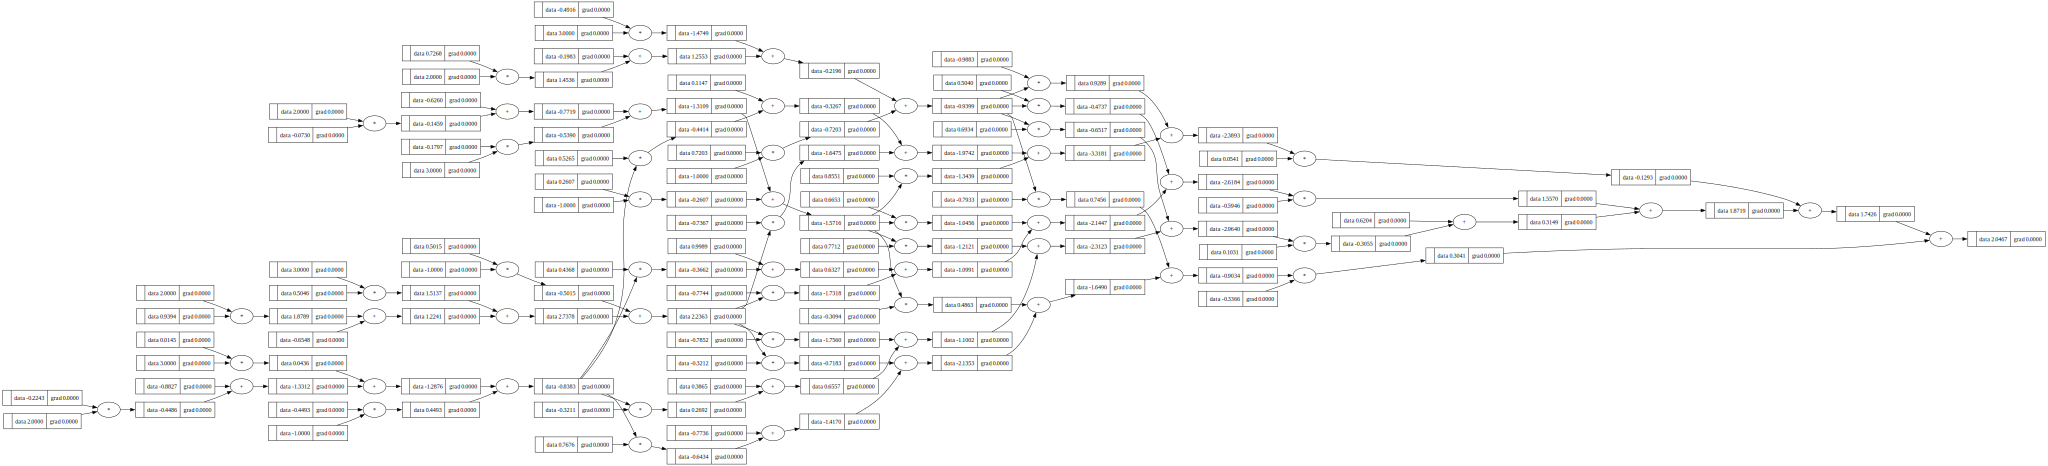

In [21]:
draw_dot(n(x))

In [22]:
x = [
    [1.,2.,3.],
    [3.,2.,4.],
    [-3.,2.,-2],
    [1.5,1.,-1]
]
y = [1,1,0,0]

n = MLP(3, [4, 4, 1], activation="linear")

yhat = [n(i) for i in x]
yhat

[Value(data=3.779004185184695, grad=0.0, label=),
 Value(data=5.571799352035853, grad=0.0, label=),
 Value(data=-1.9565568497024555, grad=0.0, label=),
 Value(data=1.1654537745940794, grad=0.0, label=)]

In [23]:
# MLP --> layers --> layer --> neurons --> neuron --> weight --> grad
n.layers[0].neurons[0].w[0].grad # weight of the first neuron  MLP has layers layesrs has neurons neurons has formula formula has weights weights has grad

0.0

In [24]:
n.parameters()[0]

Value(data=-0.3739161707004499, grad=0.0, label=)

In [25]:
#gradient descent
for _ in range(201):
    yhat = [n(i) for i in x]
    loss = sum([(y - yhat)**2 for y, yhat in zip(y,yhat)])
    
    for parameter in n.parameters():
        parameter.grad = 0.
    loss.backward()

    for parameter in n.parameters():
        parameter.data += -0.001 * parameter.grad
    
    if _ % 10 ==0:
        print(_, loss.data)

0 33.810610783382685
10 0.22382925651457405
20 0.04770559069059084
30 0.018545983541250362
40 0.007950419106380703
50 0.0035263435149289566
60 0.0016505502732196693
70 0.0008532332147316368
80 0.000513843988582007
90 0.00036905750845016153
100 0.00030700142906160536
110 0.0002801235262870739
120 0.0002682061256148655
130 0.0002626521829045818
140 0.000259805810081482
150 0.0002581123189484089
160 0.00025691057605106574
170 0.00025591943997071363
180 0.0002550193604304318
190 0.0002541595009578538
200 0.00025331824302266367


In [26]:
yhat, y

([Value(data=0.988652507120602, grad=-0.022694985758795916, label=),
  Value(data=1.0096651361912128, grad=0.019330272382425573, label=),
  Value(data=0.0042435838799402825, grad=0.008487167759880565, label=),
  Value(data=-0.003623504744566519, grad=-0.007247009489133038, label=)],
 [1, 1, 0, 0])

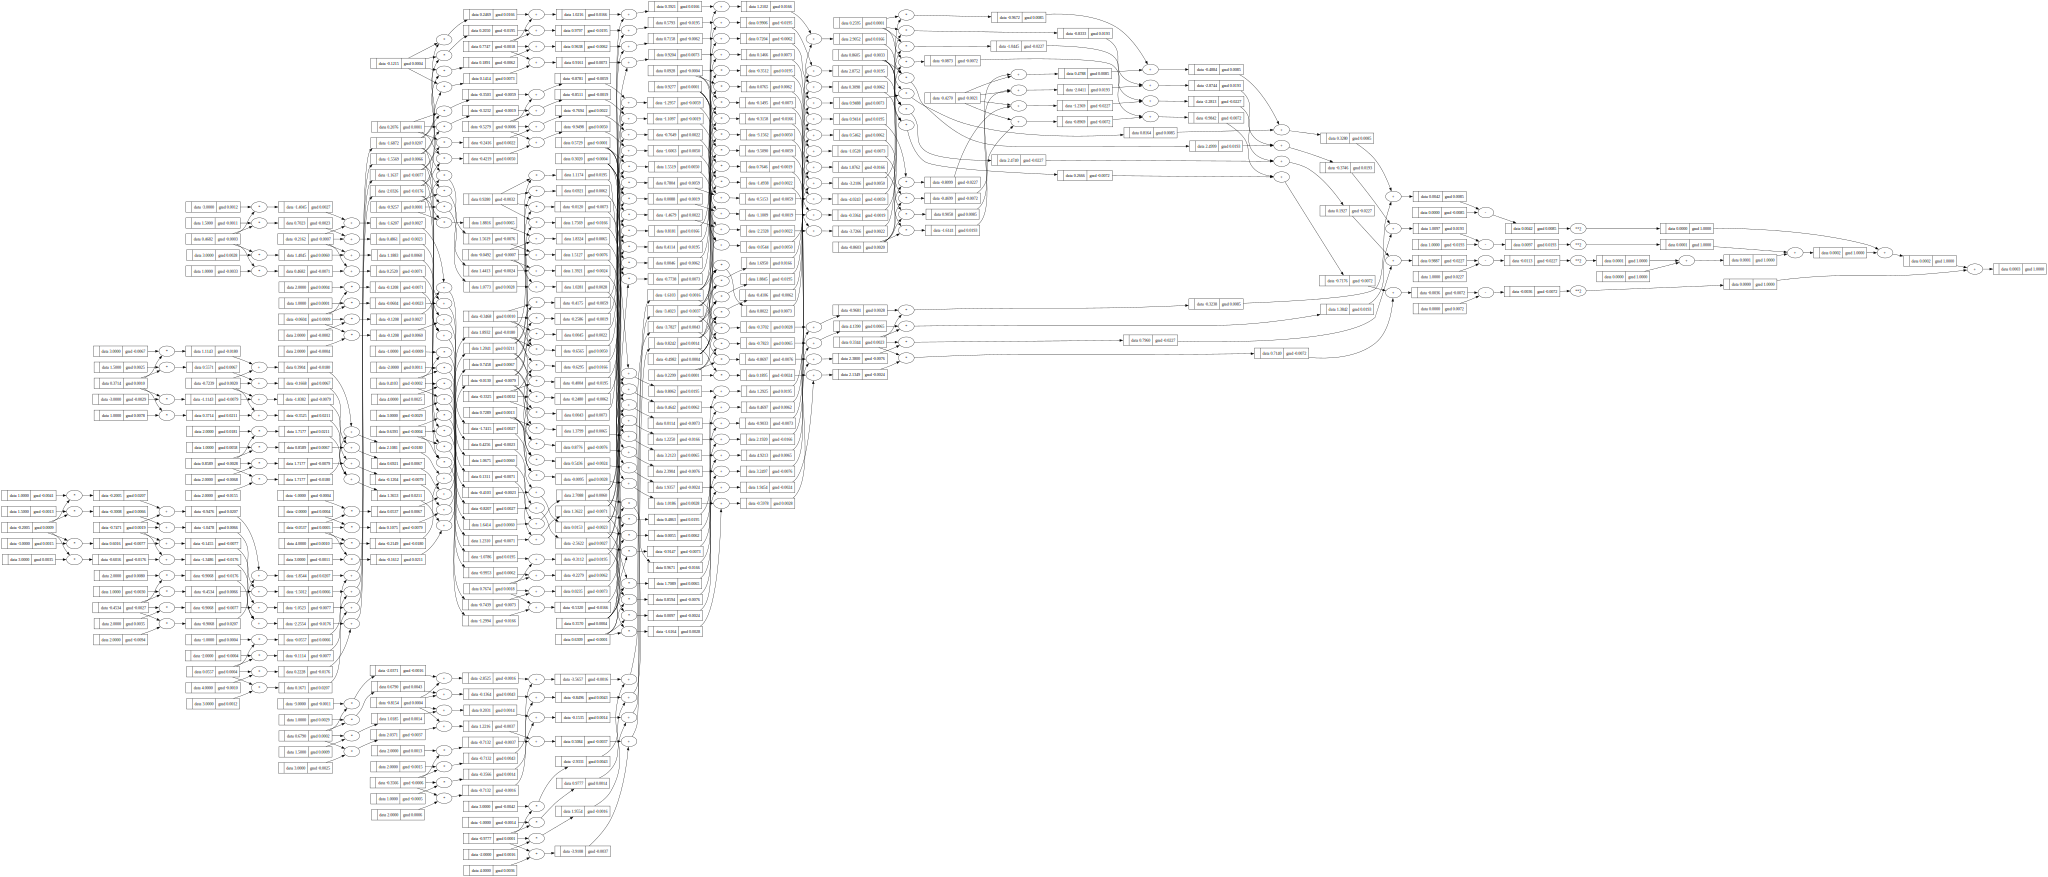

In [27]:
draw_dot(loss)

In [28]:
x = [
    [1.,2.,3.],
    [3.,2.,4.],
    [-3.,2.,-2],
    [1.5,1.,-1]
]
y = [1,1,0,0]

n = MLP(3, [4, 4, 1], activation="linear")

In [29]:
import numpy as np
#adam
learning_rate = 0.001
beta1=0.9
beta2=0.999
epsilon=1e-8
t = 0

for _ in range(201):
    t += 1
    yhat = [n(i) for i in x]
    loss = sum([(y - yhat)**2 for y, yhat in zip(y,yhat)])
    
    m = [np.zeros_like(param.data) for param in n.parameters()]
    v = [np.zeros_like(param.data) for param in n.parameters()]
    
    for parameter in n.parameters():
        parameter.grad = 0.
        
    loss.backward()

    for i, parameter in enumerate(n.parameters()):
        m[i] = beta1 * m[i] + (1 - beta1) * parameter.grad
        v[i] = beta2 * v[i] + (1 - beta2) * (parameter.grad ** 2)
        
        m_hat = m[i] / (1 - beta1 ** t)
        v_hat = v[i] / (1 - beta2 ** t)
        
        parameter.data -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        if _ % 10 ==0:
            print(_, loss.data)

0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
0 5.143585913714928
10 4.500360814898733
10 4.500360814898733
10 4.500360814898733
10 4.500360814898733
10 4.500360814898733
10 4.500360814898733
10 4.500360814898733
10 4.500360814898733
10 4.5003608

160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
160 0.09285704983297915
170 0.0326749939

In [30]:
yhat, y

([Value(data=0.9681844228922964, grad=-0.0636311542154071, label=),
  Value(data=0.9693603684593557, grad=-0.061279263081288615, label=),
  Value(data=-0.031029224511915476, grad=-0.06205844902383095, label=),
  Value(data=0.008134732928517574, grad=0.016269465857035148, label=)],
 [1, 1, 0, 0])

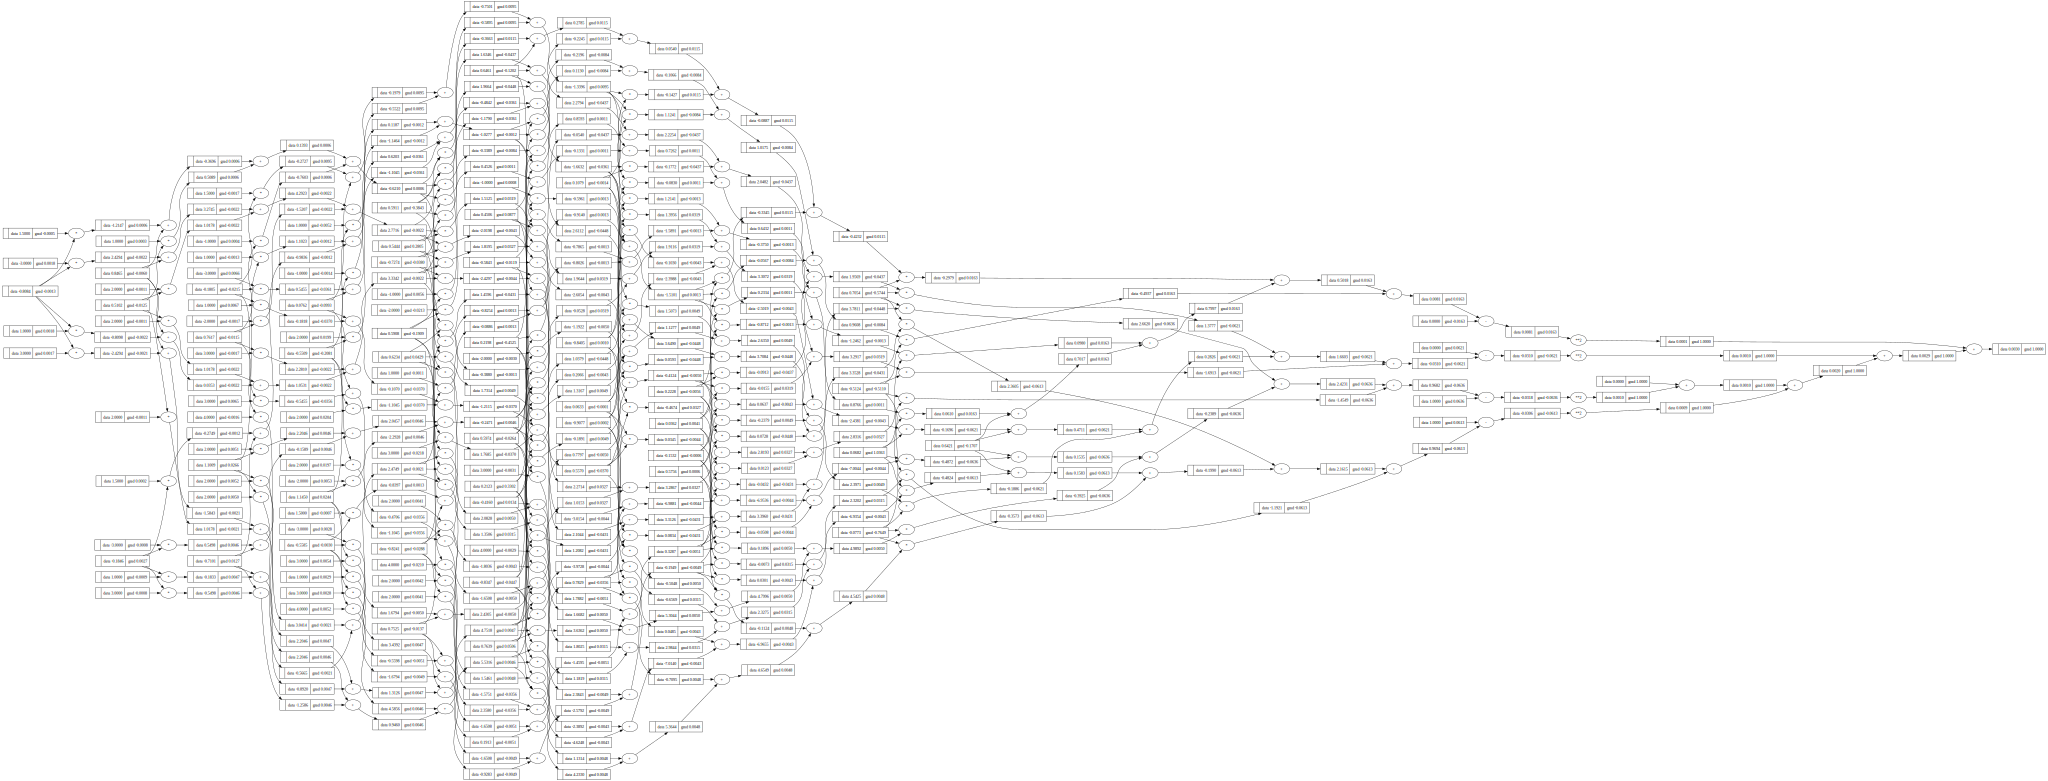

In [31]:
draw_dot(loss)